In [2]:
import os
import cv2
import math
from random import shuffle

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torchvision.io import read_image
from torchvision.utils import make_grid
import torch.nn.functional as F

In [13]:
import sys
sys.path.append("..")
from utils import tensor2img, batch_pairwise_distance

## Plot a grid of random training image
This is just to show a selection of what random training images look like 

In [ ]:
n_row = 10
n_col = 10
n_ims = n_row * n_col

train_gt_dir = "/work3/s204163/data/ImageNet/train/"
all_im_paths = os.listdir(train_gt_dir)
shuffle(all_im_paths)

fig, axes = plt.subplots(nrows=n_row, ncols=n_col, figsize=(20,20))
for idx, im_path in enumerate(all_im_paths[:n_ims]):
    im = plt.imread(f"{train_gt_dir}/{im_path}")
    row = idx // n_col
    col = idx % n_col
    axes[row, col].axis("off")
    axes[row, col].imshow(im, cmap="gray", aspect="auto")
plt.subplots_adjust(wspace=.01, hspace=.01)
plt.savefig("plots/random_train_images.png", bbox_inches='tight')
plt.show()

## Visualize the best-buddy patch for a given image

In [3]:
def idx2coords(im, id:int, ksize:int) -> tuple[int, int]:
    """ Convert an 'F.unfold-index' to a x,y position on an image"""
    W,H,_ = im.shape
    w,h = W // ksize, H // ksize
    x = math.floor(id / w) % w
    y = math.floor(id % h)
    return x * ksize, y * ksize

In [42]:
def mark_patch(im, k:int, patch_id:int, ksize:int, im_name:str, save_patches:bool=True):
    """
    Mark a patch with colored box by patch_id from F.unfold
    Patch will be blue for the original patch and red for the best-buddies
    """
    x,y = idx2coords(im, patch_id, ksize)
    
    # Hacky way of avoiding annoying overflow
    if im.shape[0] <= x+ksize: x -= 1
    if im.shape[1] <= y+ksize: y -= 1
    
    # Save the plot
    if save_patches:
        cv2.imwrite(f"plots/bestbuddy_{im_name}_{k-1}.png", im[x:x+ksize,y:y+ksize,:])
    
    # Draw rectangles
    color = np.array([0,0,255]) if k == 1 else np.array([255,0,0])
    im[x,y:y+ksize,:] = color
    im[x+ksize,y:y+ksize,:] = color
    im[x:x+ksize,y,:] = color
    im[x:x+ksize,y+ksize,:] = color
    
    return im

In [36]:
# This is a modified version of the BestBuddyLoss found in our loss.py file. 
# It is modified to return the top k closest neighbours i.e. best-buddies of a given patch, 
# instead of the usual loss between the gt and bb patch.

class BestBuddyLoss(nn.Module):
    """ https://github.com/dvlab-research/Simple-SR/blob/08c71e9e46ba781df50893f0476ecd0fc004aa45/utils/loss.py#L54 """
    def __init__(self, alpha:float=1.0, beta:float=1.0, ksize:int=3, pad:int=0, stride:int=3, dist_norm:str='l2', criterion:str='l1') -> None:
        """ """
        super(BestBuddyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.ksize = ksize
        self.pad = pad
        self.stride = stride
        self.dist_norm = dist_norm

        if criterion == 'l1':
            self.criterion = torch.nn.L1Loss()
        elif criterion == 'l2' or criterion == 'mse':
            self.criterion = torch.nn.MSELoss()
        else:
            raise NotImplementedError('%s criterion has not been implmented.' % criterion)

    def forward(self, x, gt, k=2):
        p1 = F.unfold(x, kernel_size=self.ksize, padding=self.pad, stride=self.stride)
        B, C, H = p1.size()
        p1 = p1.permute(0, 2, 1).contiguous() # [B, H, C]

        p2 = F.unfold(gt, kernel_size=self.ksize, padding=self.pad, stride=self.stride)
        p2 = p2.permute(0, 2, 1).contiguous() # [B, H, C]

        gt_2 = F.interpolate(gt, scale_factor=0.5, mode='bicubic', align_corners = False)
        p2_2 = F.unfold(gt_2, kernel_size=self.ksize, padding=self.pad, stride=self.stride)
        p2_2 = p2_2.permute(0, 2, 1).contiguous() # [B, H, C]

        gt_4 = F.interpolate(gt, scale_factor=0.25, mode='bicubic',align_corners = False)
        p2_4 = F.unfold(gt_4, kernel_size=self.ksize, padding=self.pad, stride=self.stride)
        p2_4 = p2_4.permute(0, 2, 1).contiguous() # [B, H, C]
        p2_cat = torch.cat([p2, p2_2, p2_4], 1)

        score1 = self.alpha * batch_pairwise_distance(p1, p2_cat, self.dist_norm)
        score = score1 + self.beta * batch_pairwise_distance(p2, p2_cat, self.dist_norm) # [B, H, H]

        weight, ind = torch.kthvalue(score, dim=2, k=k) # [B, H]
        index = ind.unsqueeze(-1).expand([-1, -1, C]) # [B, H, C]
        sel_p2 = torch.gather(p2_cat, dim=1, index=index) # [B, H, C]
        return p1.squeeze(), sel_p2.squeeze(), index.squeeze()

In [37]:
im_name = "img_023"
test_im = f"/work3/s204163/data/Urban100/LRbicx4/{im_name}.png"
im = read_image(test_im).float().unsqueeze(0) / 255.0

bestbuddy = BestBuddyLoss(ksize=15, stride=15)

In [43]:

target_patch = 22   # The patch to find the best-buddies of
n_patches = 10      # Num best-buddies to draw
ksize = 15          # Patchsize

out_im = tensor2img(im)
for k in range(1, n_patches+2):
    # Get the kth nearest patch
    p1, p2, index = bestbuddy(im, im, k = k)
    i = index[target_patch,:ksize**2].numpy().reshape(ksize,ksize)[0,0] # probably not the fastest way of getting the index
    out_im = mark_patch(out_im, k, i, ksize, im_name, save_patches=False)

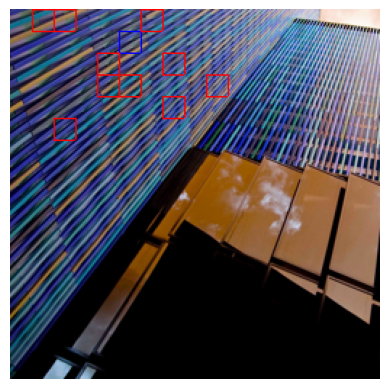

In [47]:
img = plt.imshow(out_im)
plt.axis('off')
plt.savefig(f"plots/besbuddy_{im_name}.png", bbox_inches='tight')
plt.show()